# Captioning

## Introduction
Nous arrivons enfin à l'étape finale de notre projet. Maintenant que nous avons triés nos photos avec le [classifieur binaire](./classification-binaire.ipynb) et nettoyés ces photos avec le [denoising auto encoder](./denoising-autoencoder.ipynb), nous allons nous attaquer au légendage (captioning) des photos. Pour cela nous entraîneront notre modèle avec le dataset COCO2014.

## 0. Imports & variables

In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab

import random
import string
import datetime

import cv2
import os
from pickle import dump, load
import json
from itertools import islice

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score 

from rouge import Rouge

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

from keras.layers import add

from tensorflow.keras.models import Model, load_model

from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2113264\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Chargement des données
Chargeons les données su dataset COCO2014. Ce dataset contient un grand nombre d'images différentes qui sont déjè légendées. Cela nous permettra d'entraîner le modèle à reproduire ces légendes.

In [2]:
coco=COCO("./captionning_data/annotations/instances_train2014.json")

loading annotations into memory...
Done (t=8.47s)
creating index...
index created!


In [3]:
imgIdss = coco.getImgIds()

print("Nombre d'images :", len(imgIdss))

Nombre d'images : 82783


Le dataset contient des images catégorisées. Nous allons les mélanger afin d'assurer une distribution uniforme.

In [4]:
import random
random.shuffle(imgIdss)

Visualisons quelques images.

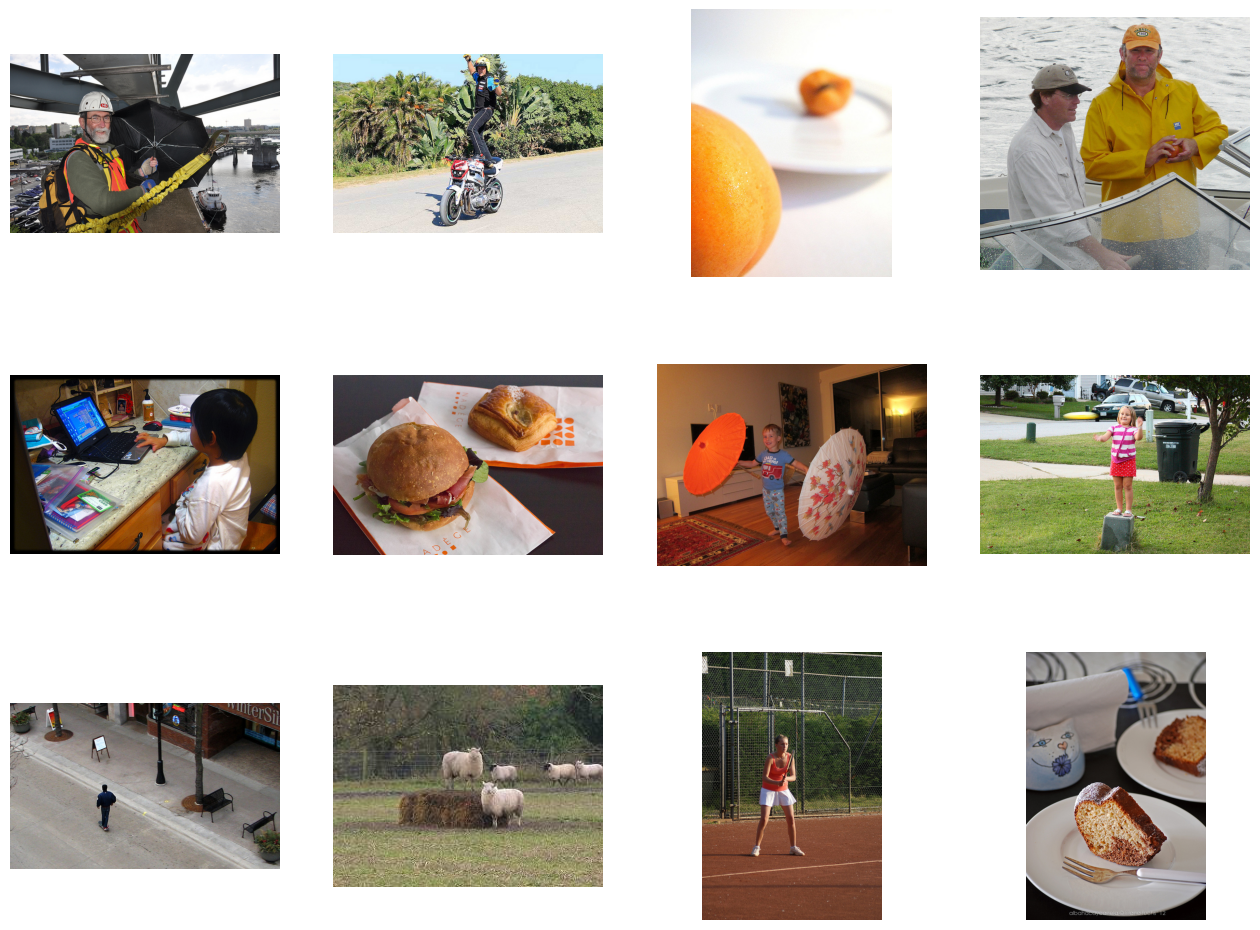

In [5]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

In [6]:
annFile = "./captionning_data/annotations/captions_train2014.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


Visualisons quelques images et les captions associées.

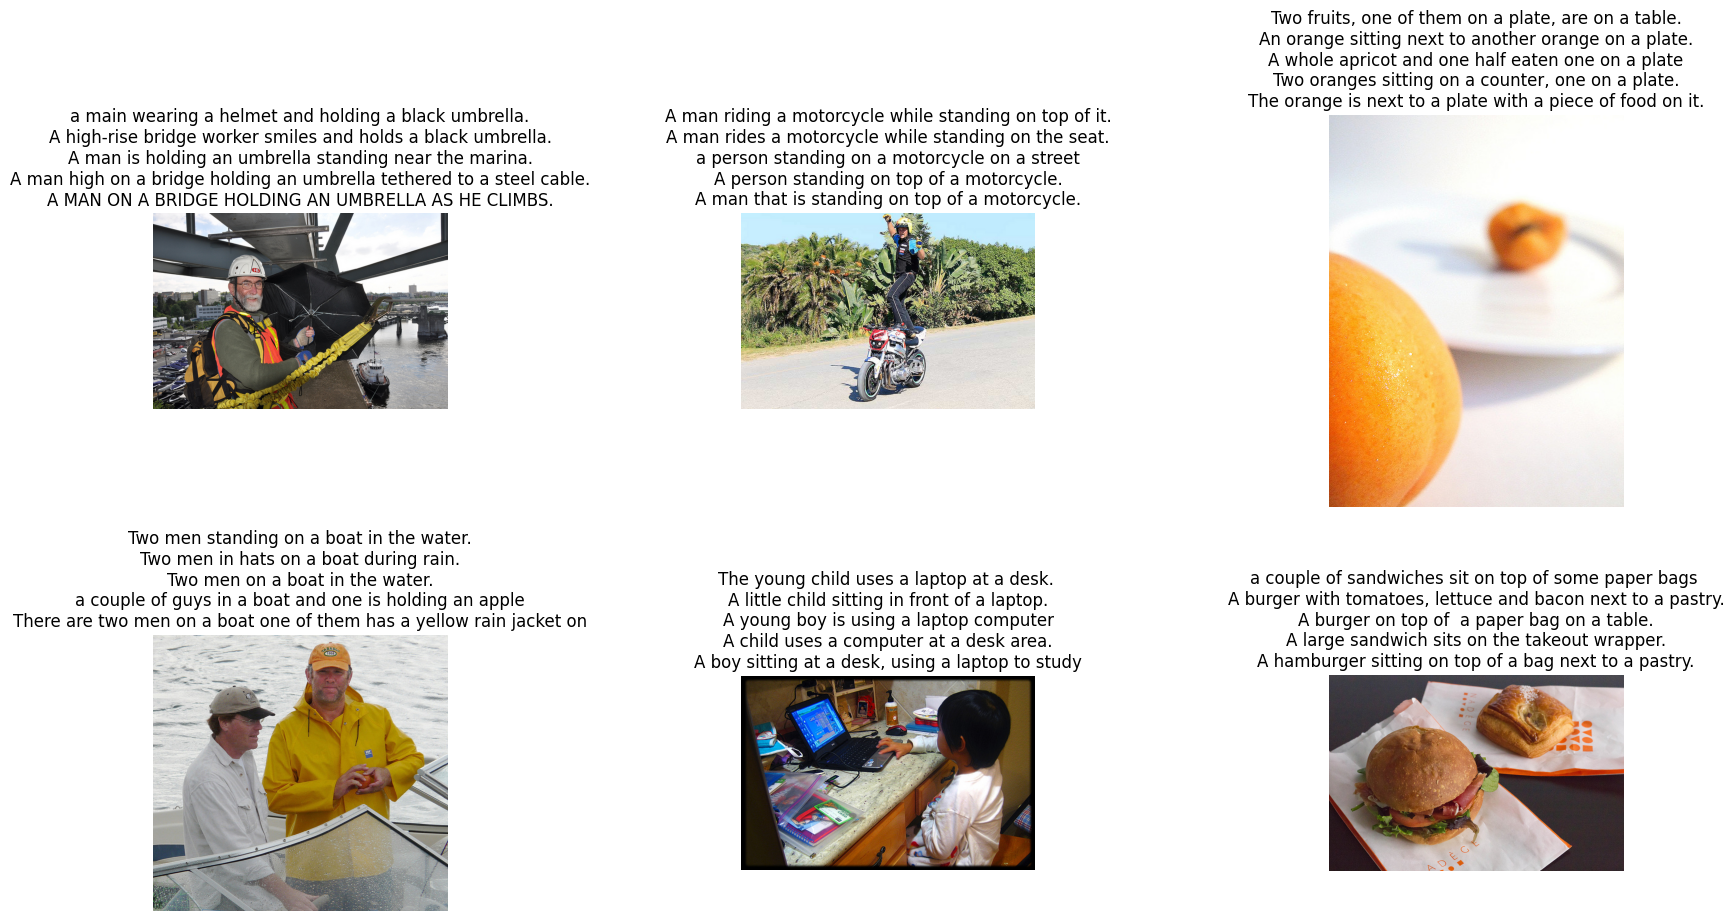

In [7]:
plt.figure(figsize=(15, 10))

for idx, image_id in enumerate(next_pix[:6]):
    img = coco.loadImgs(image_id)[0]
    I = io.imread(img['coco_url'])

    plt.subplot(2, 3, idx+1)
    plt.imshow(I)
    plt.axis('off')

    annIds = coco_caps.getAnnIds(imgIds=img['id'])
    anns = coco_caps.loadAnns(annIds)
    captions = '\n'.join([ann['caption'] for ann in anns])
    plt.title(captions)

plt.tight_layout()
plt.subplots_adjust(wspace=1)
plt.show()


## 2. Pré-traitement des données

Afin de rendre les images et les captions facilement traitables par le modèle, il convient d'effectuer différents traitements au préalable.

### 2.1. Traitement des captions

Voici les différents traitements effectués sur les captions afin d'aider le modèle à mieux les comprendre et à généraliser :
- Suppression de la ponctuation => Réduction du nombre de tokens en supprimant des informations peu décisives.
- Remplacement des tirets par des espaces => Réduction du nombre de tokens en supprimant des informations peu décisives.
- Transformation des lettres en minuscule => Réduction du nombre de tokens en supprimant des informations peu décisives.
- Ajout de balises "\<start>" et "\<end>" en début et fin de caption => Ajout d'information afin que le modèle sache quand débuter une nouvelle caption et quand la finir.

In [8]:
dataset = dict()
imgcaptions = []

for imgid in tqdm(imgIdss):
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    
    for cap in anns:
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        cap = cap.replace("-"," ")
        cap = cap.split()
        cap = [word.lower() for word in cap]
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset['./captionning_data/train2014/' + img['file_name']] = imgcaptions 
    
    
print("Taille du dataset: ",len(dataset))

  0%|          | 0/82783 [00:00<?, ?it/s]

Taille du dataset:  82783



   - Les légendes, organisées en structures imbriquées, sont transformées en une liste unique pour simplifier leur traitement.
   - Les légendes sont converties en séquences de tokens (ou de mots) à l'aide d'un tokenizer. 
   - Chaque mot dans une légende est remplacé par un numéro unique, facilitant le traitement numérique.
   - Si un mot inconnu est rencontré, il est remplacé par le token '<oov>' (out of vocabulary).
   - Cela permet de gérer les mots inconnus sans perturber le processus.

In [11]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values()))

tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1
with open('./tokenizer.pkl', 'wb') as file:
    tokenizer = dump(tokenizer, file)
print("Taille du vocabulaire: ", total_words)

Taille du vocabulaire:  24782


### 2.2. Traitement des images

Un modèle pré-entraîné `Xception` est utilisé pour extraire les caractéristiques des images. Ce modèle est configuré pour exclure sa dernière couche, car nous voulons seulement les caractéristiques, et non les prédictions.
Les modèles pré-entraînés, comme `Xception`, ont été formés sur de vastes ensembles de données et ont déjà appris de nombreuses caractéristiques générales des images.   
Utiliser un tel modèle permet d'économiser du temps et des ressources car nous bénéficions de la "connaissance" qu'il a déjà acquise. Au lieu d'entraîner un modèle à partir de zéro, nous utilisons et adaptons ce qu'il a déjà appris.   
   

Xception offre d'excellentes performances sur les benchmarks et est comparable, voire supérieur, à d'autres architectures telles que VGG et ResNet pour certaines tâches.
Contrairement à d'autres modèles très profonds, Xception trouve un bon équilibre entre la profondeur du modèle et la performance, ce qui le rend efficace tout en évitant des temps d'entraînement trop longs.
Bien que VGG soit une architecture solide, elle est beaucoup plus lourde en termes de paramètres par rapport à Xception. Cela rend Xception plus rapide à entraîner et à inférer.
ResNet introduit des connexions résiduelles pour résoudre le problème de la disparition du gradient dans les réseaux profonds. Xception, tout en bénéficiant de cette idée, ajoute également les convolutions séparables en profondeur pour améliorer l'efficacité.

Xception est un choix judicieux pour le captioning d'images en raison de son équilibre entre performance et efficacité, en le comparant à d'autres modèles populaires.


Dans le contexte du captionning d'images, ces caractéristiques extraites sont essentielles. Elles fournissent un résumé riche de l'information contenue dans l'image, facilitant la génération de légendes pertinentes. Comme `Xception` a été formé sur un large éventail d'images, il est capable d'identifier et d'extraire des caractéristiques pertinentes de presque n'importe quelle image, rendant les légendes générées plus précises et contextuellement appropriées.

- Les images sont traitées par lots pour optimiser la performance.
- Conversion des images en niveau de gris en couleur.
- Redimensionnement de l'image pour qu'elle corresponde à la taille d'entrée attendue par le modèle `Xception` (299x299 pixels).
- Normalisation des pixels pour les mettre à une échelle [-1, 1].

- Les images prétraitées sont passées à travers le modèle `Xception` pour obtenir leurs caractéristiques.


In [10]:
image_features = {}

filename = './image_features.pkl'
BATCH_SIZE = 8 

if os.path.exists(filename):
    with open(filename, 'rb') as file:
        image_features = load(file)
    print("Features chargées depuis le fichier.")
else:
    model = Xception(include_top=False, pooling='avg')
    
    images_list = list(dataset.keys())
    num_batches = len(images_list) // BATCH_SIZE + (1 if len(images_list) % BATCH_SIZE != 0 else 0)
    
    for i in tqdm(range(num_batches)):
        batch_images = images_list[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_data = []
        
        for img in batch_images:
            try:
                image = io.imread(img)
                if image.ndim != 3:
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                image = cv2.resize(image, (299, 299))
                batch_data.append(image)
            except Exception as e:
                print(f"Erreur de traitement sur {img} : {e}")
        
        batch_data = np.array(batch_data)
        batch_data = batch_data / 127.5
        batch_data = batch_data - 1.0

        batch_features = model.predict(batch_data, verbose=False)
        
        for img, feature in zip(batch_images, batch_features):
            image_features[img] = feature

    with open(filename, 'wb') as file:
        dump(image_features, file)

print("Taille de la liste de features: ", len(image_features))

Features chargées depuis le fichier.
Taille de la liste de features:  82783


In [18]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(dataset)
print(f"Taille de la plus grande caption : {max_length} mots")

Taille de la plus grande caption : 51 mots


La fonction `data_generator` produit des données d'entrée et de sortie adaptées pour l'entraînement du modèle de captioning.   
Pour chaque image, nous avons plusieurs descriptions. Le générateur itère sur chaque description et produit un ensemble de séquences adaptées pour l'entraînement.
   
La fonction `create_sequences` prépare des séquences à partir des descriptions fournies pour une image donnée.
Pour chaque description, elle divise la description en plusieurs sous-séquences. Par exemple, pour la description "un chat dort", les sous-séquences pourraient être "un", "un chat" et "un chat dort".
Cette division est essentielle car elle permet au modèle d'apprendre à prédire le prochain mot d'une séquence. Ainsi, il apprend à générer une description mot par mot.
   
Ces étapes préparent les données de manière à ce que le modèle puisse être entraîné pour associer les fonctionnalités d'une image à une séquence de mots, tout en prédisant également le prochain mot de la séquence.
En d'autres termes, cela forme le modèle pour regarder une image, commencer une description et continuer à prédire la description mot par mot jusqu'à ce qu'il génère une légende complète pour l'image.
Cette approche séquentielle est cruciale pour que le modèle comprenne la structure grammaticale des descriptions et produise des légendes qui sont non seulement pertinentes, mais aussi fluides et naturelles.


In [12]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    for desc in desc_list:
        
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
            
    return np.array(X1), np.array(X2), np.array(y)

Maintenant que nos données ont été traitées, nous allons diviser notre dataset en jeu d'entraînement, de validation et de test, comme nous l'avons fait pour les modèles précédents.

In [13]:
assert set(dataset.keys()) == set(image_features.keys())

keys = list(dataset.keys())

train_keys, temp_keys = train_test_split(keys, test_size=0.2, random_state=42)
val_keys, test_keys = train_test_split(temp_keys, test_size=0.20, random_state=42)

train_descriptions = {k: dataset[k] for k in train_keys}
val_descriptions = {k: dataset[k] for k in val_keys}
test_descriptions = {k: dataset[k] for k in test_keys}

train_features = {k: image_features[k] for k in train_keys}
val_features = {k: image_features[k] for k in val_keys}
test_features = {k: image_features[k] for k in test_keys}

train_generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
val_generator = data_generator(val_descriptions, val_features, tokenizer, max_length)

train_steps = len(train_descriptions)
val_steps = len(val_descriptions)

## 3. Création du modèle

Pour le captioning de nos images, notre modèle traitera deux types de données en entrée :

- Les features extraites par Xception: Ces features constituent la représentation profonde de nos images et contiennent l'information nécessaire pour comprendre le contenu visuel.

- Les captions associées: Les captions servent de descriptions textuelles de nos images. Pour traiter ces séquences textuelles, nous utilisons **LSTM (Long Short-Term Memory)**.

Les LSTM sont spécialement conçus pour gérer les dépendances à long terme dans les séquences de données. Cela est essentiel pour comprendre et générer des descriptions précises pour les images.
Les LSTM peuvent gérer efficacement des séquences de longueurs différentes, ce qui est crucial étant donné que les descriptions peuvent varier en longueur.   

Il est à noter que la technologie la plus en vogue aujourd'hui pour traiter les séquences est les Transformers. Les Transformers ont révolutionné le domaine du traitement du langage naturel avec des modèles comme BERT, GPT, et d'autres, surpassant les performances des LSTM dans de nombreuses tâches. Cependant, leur complexité et leur taille signifient qu'ils nécessitent une puissance de calcul considérable pour l'entraînement.

Malheureusement, notre puissance de calcul actuelle ne nous permet pas d'entraîner ces modèles volumineux. Par conséquent, nous nous en tiendrons à la technologie éprouvée des LSTM pour notre tâche de captioning.   
   
Voici une description du modèle utilisé :   

![image.png](./images/captioner.png) 

In [21]:
def define_model(total_words, max_length):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='./images/captioner.png', show_shapes=True)

    return model

model = define_model(total_words, max_length)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 51, 256)      6344192     ['input_8[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_7[0][0]']                
                                                                                            

## 4. Entraînement du modèle
Vous pouvez suivre l'avancée de l'entrainement avec la commande `tensorboard --logdir logs/fit/captioner --bind_all`

In [22]:
print('Dataset: ', len(dataset))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Descriptions: val=', len(val_descriptions))
print('Photos: val=', len(val_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)
model = define_model(total_words, max_length)
steps = len(dataset)

date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/captioner/" + date
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_directory = f"weights/captioner/{date}/"
os.makedirs(model_checkpoint_directory, exist_ok=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

model.fit(train_generator, 
          epochs=10,
          steps_per_epoch=train_steps, 
          validation_data=val_generator, 
          validation_steps=val_steps, 
          callbacks=[tensorboard_callback, model_checkpoint_callback])

Dataset:  82783
Descriptions: train= 66226
Photos: train= 66226
Descriptions: val= 13245
Photos: val= 13245
Vocabulary Size: 24782
Description Length:  51
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 51, 256)      6344192     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None,

KeyboardInterrupt: 

![image.png](./images/captioner_loss.png)   

On peut voir qu'après la première époque, la perte du jeu de validation (en gris) a tendance à augmenter. Et, rapidement, la perte du jeu d'entraînement (en vert) a aussi tendance à augmenter.   
C'est un cas de sur-apprentissage. Cela signifie que lors de la première époque, le grand volume de données traitées par le modèle est suffisant pour l'entraînement.   
   
Nous allons donc charger les poids de la première époque.

In [26]:
model.load_weights("weights/captioner/20231025-171500/01-3.0579.h5")

In [27]:
model.save("models/captioner.h5")

## 5. Test du modèle

Pour garantir que notre modèle de captioning fonctionne bien et produit des descriptions d'images de qualité, il est crucial de le tester et de mesurer ses performances.

Voici comment nous allons évaluer notre modèle :

| Métrique       | Éléments Pris en Compte                                       | Ce que ça Mesure                                                                                                  | Comment Lire la Valeur                                                      |
|----------------|---------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------|
| **Loss**       | Différences entre prédictions et réponses vraies              | Si le modèle fait beaucoup ou peu d'erreurs pendant l'entraînement.                                                 | Une valeur plus basse signifie moins d'erreurs.                             |
| **BLEU Score** | Correspondance des mots et groupes de mots                    | Combien les mots prédits ressemblent aux mots réels.                            | Plus proche de 1, meilleure est la ressemblance.                            |
| **ROUGE-L Score** | Séquences de mots en commun                                  | La longueur de la plus grande suite de mots que les prédictions ont en commun avec les vraies descriptions.        | Plus proche de 1, plus les prédictions et les vraies phrases sont similaires.|
| **Meteor Score**  | Synonymes, racines des mots et correspondances                | La qualité globale de la description, en tenant compte des synonymes et des variations de mots.                     | Plus proche de 1, meilleure est la qualité de la description.               |

Ces méthodes d'évaluation nous donnent une idée complète de la manière dont notre modèle fonctionne et où il pourrait avoir besoin d'améliorations.


In [28]:
model = load_model("models/captioner.h5")

In [29]:
test_generator = data_generator(test_descriptions, test_features, tokenizer, max_length)
test_steps = len(test_descriptions)
test_loss = model.evaluate(test_generator, steps=test_steps)

print(f"Test loss: {test_loss}")

3312/3312 [==============================] - 124s 37ms/step - loss: 3.0734
Test loss: 3.0734052658081055


In [40]:
def generate_descriptions_batch(model, tokenizer, photos, max_length):
    batch_size = photos.shape[0]
    batch_descriptions = ['start'] * batch_size

    for _ in range(max_length):
        sequences = tokenizer.texts_to_sequences(batch_descriptions)
        sequences = pad_sequences(sequences, maxlen=max_length)
        
        preds = model.predict([photos, sequences], verbose=0)
        
        for i, pred in enumerate(preds):
            pred_word_index = np.argmax(pred)
            word = tokenizer.index_word.get(pred_word_index, '')
            
            if word == 'end' or len(batch_descriptions[i].split()) > max_length:
                continue
            
            batch_descriptions[i] += ' ' + word
    
    return batch_descriptions

batch_size = 64
predicted_descriptions = {}
for i in tqdm(range(0, len(test_features), batch_size)):
    batch_keys = list(test_features.keys())[i:i+batch_size]
    images = np.array([test_features[key] for key in batch_keys])
    batch_predicted = generate_descriptions_batch(model, tokenizer, images, max_length)
    
    for j, key in enumerate(batch_keys):
        predicted_descriptions[key] = batch_predicted[j]


  0%|          | 0/52 [00:00<?, ?it/s]

In [42]:
chencherry = SmoothingFunction()
bleu_scores = []
keys = list(test_descriptions.keys())
for key in keys:
    references = [d.split() for d in test_descriptions[key]]
    candidate = predicted_descriptions[key].split()
    bleu_scores.append(sentence_bleu(references, candidate, smoothing_function=chencherry.method1))
print('Average BLEU Score:', np.mean(bleu_scores))


meteor_scores = []
for key in keys:
    references = [d.split() for d in test_descriptions[key]]
    candidate = predicted_descriptions[key].split()
    meteor_scores.append(meteor_score(references, candidate))
print('Average METEOR Score:', np.mean(meteor_scores))

rouge = Rouge()
rouge_scores = []
for key in keys:
    references = [d.split() for d in test_descriptions[key]]
    candidate = predicted_descriptions[key].split()
    scores = rouge.get_scores(' '.join(candidate), ' '.join(references[0]))
    rouge_scores.append(scores[0]['rouge-l']['f'])
print('Average ROUGE-L Score:', np.mean(rouge_scores))


Average BLEU Score: 0.129036521784363
Average METEOR Score: 0.2972816024653978
Average ROUGE-L Score: 0.2500163250729907


- **BLEU Score**: Autour de 0.13
- **METEOR Score**: Autour de 0.3
- **ROUGE-L Score**: Autour de 0.25

Ces scores suggèrent que notre modèle donne des résultats moyens. Le BLEU score, étant relativement bas, indique que le choix exact des mots et des groupes de mots entre les prédictions et les références varie considérablement. Cependant, les scores METEOR et ROUGE-L, bien qu'ils ne soient pas idéaux, montrent que le modèle est capable de capturer certains éléments pertinents dans les descriptions.

Il est important de noter que ces résultats ont été obtenus malgré une faible puissance de calcul. Cette contrainte peut influer sur la capacité du modèle à s'entraîner efficacement et à atteindre son potentiel optimal.


Augmenter la puissance de calcul pourrait permettre d'entraîner le modèle plus profondément et d'obtenir des performances améliorées.
Un ensemble de données plus large peut aider le modèle à mieux généraliser et à produire des descriptions plus précises.
Il serait judicieux d'explorer d'autres architectures ou paramètres pour optimiser les performances.
Au lieu d'entraîner à partir de zéro, on peut utiliser des modèles déjà entraînés sur des tâches similaires et affiner pour notre jeu de données spécifique.   

Cela étant dit, visualisons quelques prédictions effectués par le captioner afin de comprendre dans quelles mesures le modèle est capable de capturer les features des images et de les convertir en texte.

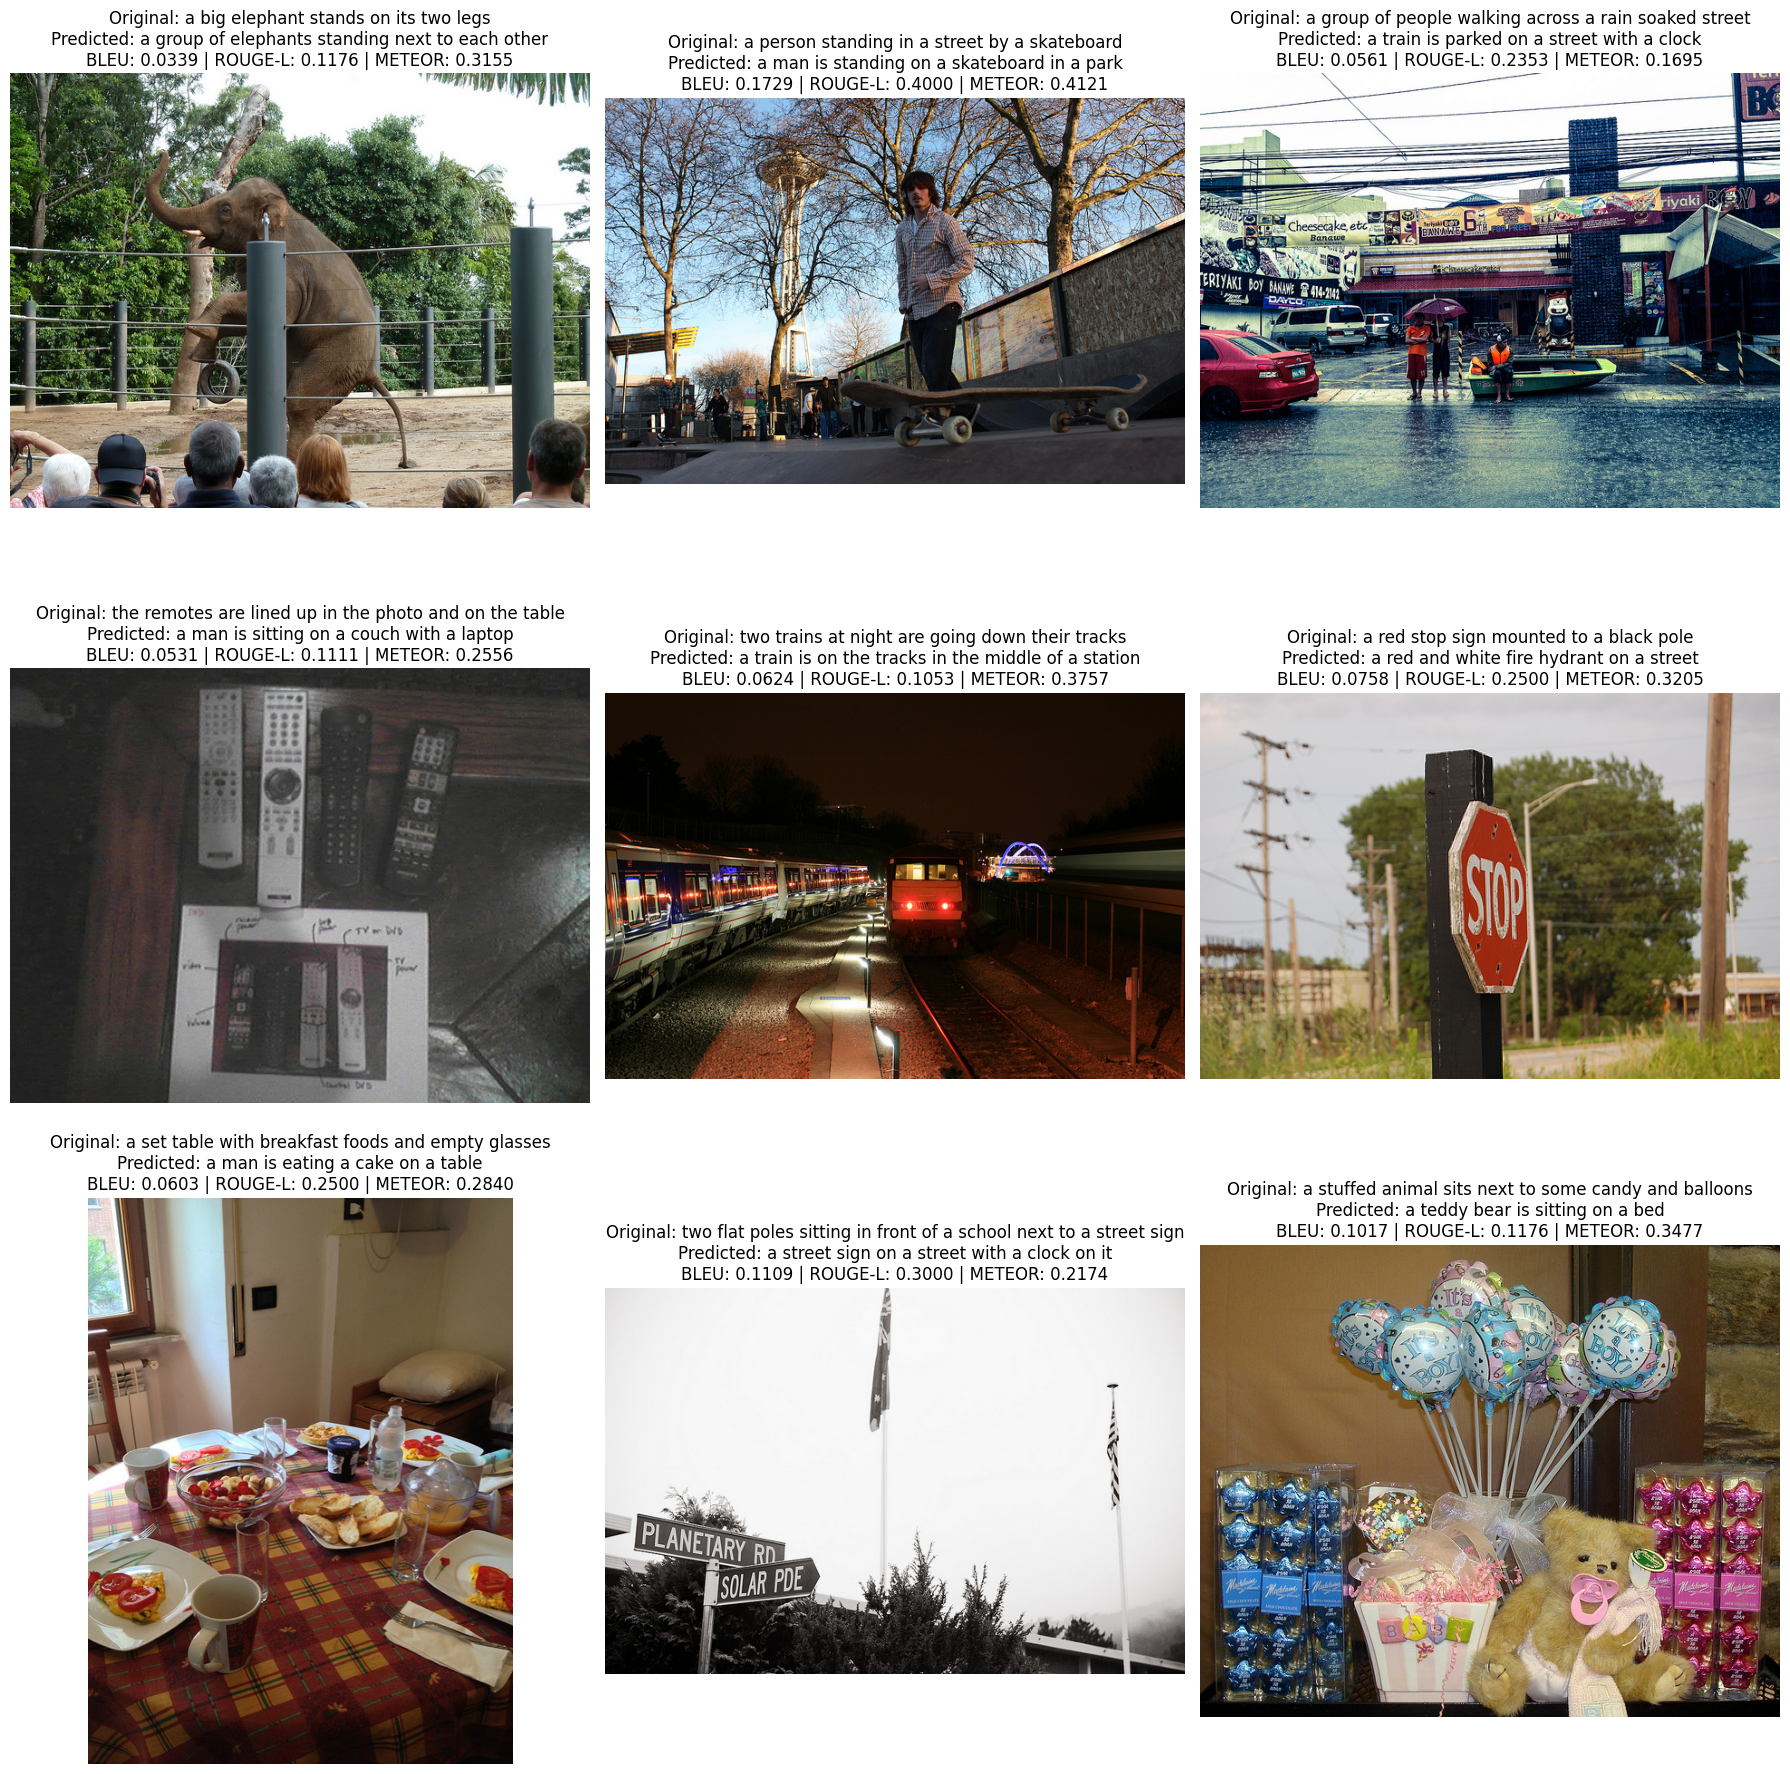

In [47]:
def load_image(img_path):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')

def display_images_and_scores(test_descriptions, predicted_descriptions):
    keys = list(test_descriptions.keys())
    selected_keys = random.sample(keys, 9)
    
    chencherry = SmoothingFunction()
    rouge = Rouge()
    
    unwanted_tokens = {"<start>", "start", "<end>", "end"}

    plt.figure(figsize=(18, 18))
    for index, key in enumerate(selected_keys):
        
        plt.subplot(3, 3, index+1)
        load_image(key)

        references = [d.split() for d in test_descriptions[key]]
        candidate = predicted_descriptions[key].split()
        
        references = [[word for word in ref if word not in unwanted_tokens] for ref in references]
        candidate = [word for word in candidate if word not in unwanted_tokens]

        bleu = sentence_bleu(references, candidate, smoothing_function=chencherry.method1)

        rouge_scores = rouge.get_scores(' '.join(candidate), ' '.join(references[0]))
        rouge_l = rouge_scores[0]['rouge-l']['f']

        meteor_s = meteor_score(references, candidate)

        original_caption = ' '.join(references[0])
        predicted_caption = ' '.join(candidate)
        
        plt.title(
            f"Original: {original_caption}\nPredicted: {predicted_caption}"
            f"\nBLEU: {bleu:.4f} | ROUGE-L: {rouge_l:.4f} | METEOR: {meteor_s:.4f}"
        )
    plt.tight_layout()
    plt.show()

display_images_and_scores(test_descriptions, predicted_descriptions)


## Conclusion

Comme nous l'avons vu précédemment, notre modèle de captionning produit des résultats moyens mais avec plus de ressources et de temps pour l'entraînement, ou pourrait améliorer ses performances.  
Ce modèle est entraîné à traiter des photos propres. Ont peut s'assurer de la qualité de nos données grâce à nos modèles de [classification binaire](./classification-binaire.ipynb) et de [denoising](denoising-autoencoder.ipynb).  
  
La dernière étape consiste à créer un [pipeline](./full-Pipeline.ipynb) qui appelle nos 3 modèles successivement afin de pouvoir générer des captions sur tous types d'images.